In [11]:
!pip install -q -U colorama

In [12]:
import os, shutil
import numpy as np
import pandas as pd
import random
import cv2
import sys
import glob
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import json

import torch

from colorama import Fore

from shapely.geometry import Polygon
import matplotlib.patches as patches

In [13]:
BASE_PATH = "/content/Dental_dataset/Childrens dental caries segmentation dataset"
TRAIN_PATH = os.path.join(BASE_PATH, "Train")
TEST_PATH = os.path.join(BASE_PATH, "Test")
SUPPLEMENTAL_PATH = os.path.join(BASE_PATH, "Supplemental content93")

print(os.listdir(BASE_PATH))

['Train', 'Test', 'Supplemental content93']


In [14]:
ANNOTATIONS_PATH = "/content/Dental_dataset/Childrens dental caries segmentation dataset/Train/annotations.json"

with open(ANNOTATIONS_PATH, "r") as json_file:
    annot_json_file = json.load(json_file)

annot_json_file.keys()

dict_keys(['categories', 'images', 'annotations', 'info', 'licenses'])

In [15]:
!pip install -q -U pycocotools

In [16]:
from pycocotools.coco import COCO

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
class ChildrenDentalRadiographsDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.label_map = {
            1: "caries",
            2: "periapical infection",
            3: "pulpitis",
            4: "deep sulcus",
            5: "dental developmental abnormalities",
            6: "others"
        }
        self.label_map2 = {
            "caries": 1,
            "periapical infection": 2,
            "pulpitis": 3,
            "deep sulcus": 4,
            "dental developmental abnormalities": 5,
            "others": 6
        }

    def __getitem__(self, idx):
        coco = self.coco
        image_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=image_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(image_id)[0]["file_name"]
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        num_objs = len(coco_annotation)

        boxes = []
        labels = []
        masks = []
        areas = []

        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

            category_id = coco_annotation[i]['category_id']
            label = self.label_map2[self.label_map[category_id]]
            labels.append(label)
            mask = coco.annToMask(coco_annotation[i])
            masks.append(mask)
            areas.append(coco_annotation[i]['area'])

        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([image_id])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

In [19]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(p=.5))
    return T.Compose(transforms)

In [20]:
TEST_ANNOTATIONS_PATH = "/content/Dental_dataset/Childrens dental caries segmentation dataset/Test/annotations.json"

In [21]:
train_ds = ChildrenDentalRadiographsDataset(root=os.path.join(TRAIN_PATH, "images"),
                                            annotation=ANNOTATIONS_PATH,
                                            transforms=get_transform(train=True))

val_ds = ChildrenDentalRadiographsDataset(root=os.path.join(TEST_PATH, "images"),
                                          annotation=TEST_ANNOTATIONS_PATH,
                                          transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [22]:
import utils
from engine import train_one_epoch

In [23]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=2,
                                       shuffle=True,
                                       num_workers=os.cpu_count(),
                                       pin_memory=True,
                                       drop_last=True,
                                       collate_fn=utils.collate_fn)

val_dl = torch.utils.data.DataLoader(val_ds,
                                     batch_size=2,
                                     shuffle=False,
                                     num_workers=os.cpu_count(),
                                     pin_memory=True,
                                     collate_fn=utils.collate_fn)

In [ ]:
# sanity check
from torchvision import transforms

for images, labels in train_dl:
    #print([{k: torch.as_tensor(v).to(device) for k,v in t.items()} for t in labels])
    img = transforms.ToPILImage()(images[0])
    plt.imshow(img)
    plt.show()
    print(labels)
    print(labels[0].keys())
    break

In [25]:
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.resnet import ResNet50_Weights

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone=ResNet50_Weights.IMAGENET1K_V2)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes)
    return model

In [26]:
from engine import evaluate
import utils

In [27]:
EPOCHS = 15

In [28]:
model = get_model_instance_segmentation(num_classes=6)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0003, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=50)
    evaluate(model, val_dl, device=device)
    scheduler.step()
    model_path = f"epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_path)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:02<00:00, 84.9MB/s]


Epoch: [0]  [ 0/35]  eta: 0:08:04  lr: 0.000009  loss: 3.7248 (3.7248)  loss_classifier: 1.8275 (1.8275)  loss_box_reg: 0.1996 (0.1996)  loss_mask: 1.0309 (1.0309)  loss_objectness: 0.6062 (0.6062)  loss_rpn_box_reg: 0.0607 (0.0607)  time: 13.8396  data: 1.3754  max mem: 3634
Epoch: [0]  [34/35]  eta: 0:00:01  lr: 0.000300  loss: 1.4475 (2.3142)  loss_classifier: 0.3726 (0.6583)  loss_box_reg: 0.6162 (0.6303)  loss_mask: 0.3513 (0.5025)  loss_objectness: 0.0960 (0.3353)  loss_rpn_box_reg: 0.0552 (0.1878)  time: 0.7876  data: 0.0008  max mem: 4557
Epoch: [0] Total time: 0:00:40 (1.1658 s / it)
creating index...
index created!
Test:  [ 0/15]  eta: 0:00:46  model_time: 1.4939 (1.4939)  evaluator_time: 1.0647 (1.0647)  time: 3.1102  data: 0.5459  max mem: 4557
Test:  [14/15]  eta: 0:00:02  model_time: 1.4286 (1.4953)  evaluator_time: 1.0713 (1.2153)  time: 2.8134  data: 0.0368  max mem: 4557
Test: Total time: 0:00:42 (2.8193 s / it)
Averaged stats: model_time: 1.4286 (1.4953)  evaluator_ti

In [ ]:
model.eval()
CLASS_NAMES = ["caries",
               "periapical infection",
               "pulpitis",
               "deep sulcus",
               "dental developmental abnormalities",
               "others"]

model.to(device)

In [30]:
def color_mask(mask):
    # defining 5 colors for segmentation
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,5)]
    coloured_mask = np.stack([r, g, b], axis=2) #stacking along channel axis
    return coloured_mask

In [34]:
sample_img="/content/Dental_dataset/Childrens dental caries segmentation dataset/Supplemental content93/images/cate1_0000.png"

In [35]:
img=Image.open(sample_img)
convert_tensor = transforms.ToTensor()
image=convert_tensor(img)
image=image.to(device)

In [37]:
pred=model([image])

In [40]:
pred[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [45]:
pred_score=list(pred[0]["scores"].detach().cpu().numpy())

In [56]:
pred_score.index(pred_score[5])

5

In [49]:
confidence=0.5
pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
pred_t

29

In [58]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()

In [59]:
pred[0]["labels"]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [60]:
pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]

In [62]:
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]

In [64]:
pred_boxes[0]

[(398.2259, 603.7107), (544.23444, 709.3845)]

In [69]:
pred_t+1

30

In [66]:
masks = masks[:pred_t+1]

In [67]:
pred_boxes = pred_boxes[:pred_t+1]

In [70]:
pred_class = pred_class[:pred_t+1]

In [71]:
def predict(img_path, confidence):

    img = Image.open(img_path)
    convert_tensor = transforms.ToTensor()

    img = convert_tensor(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

In [80]:
def visualize_predictions(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):

    masks, boxes, pred_cls = predict(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = color_mask(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.6, 0)
        boxes[i][0] = [int(i) for i in boxes[i][0]]
        boxes[i][1] = [int(i) for i in boxes[i][1]]

        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

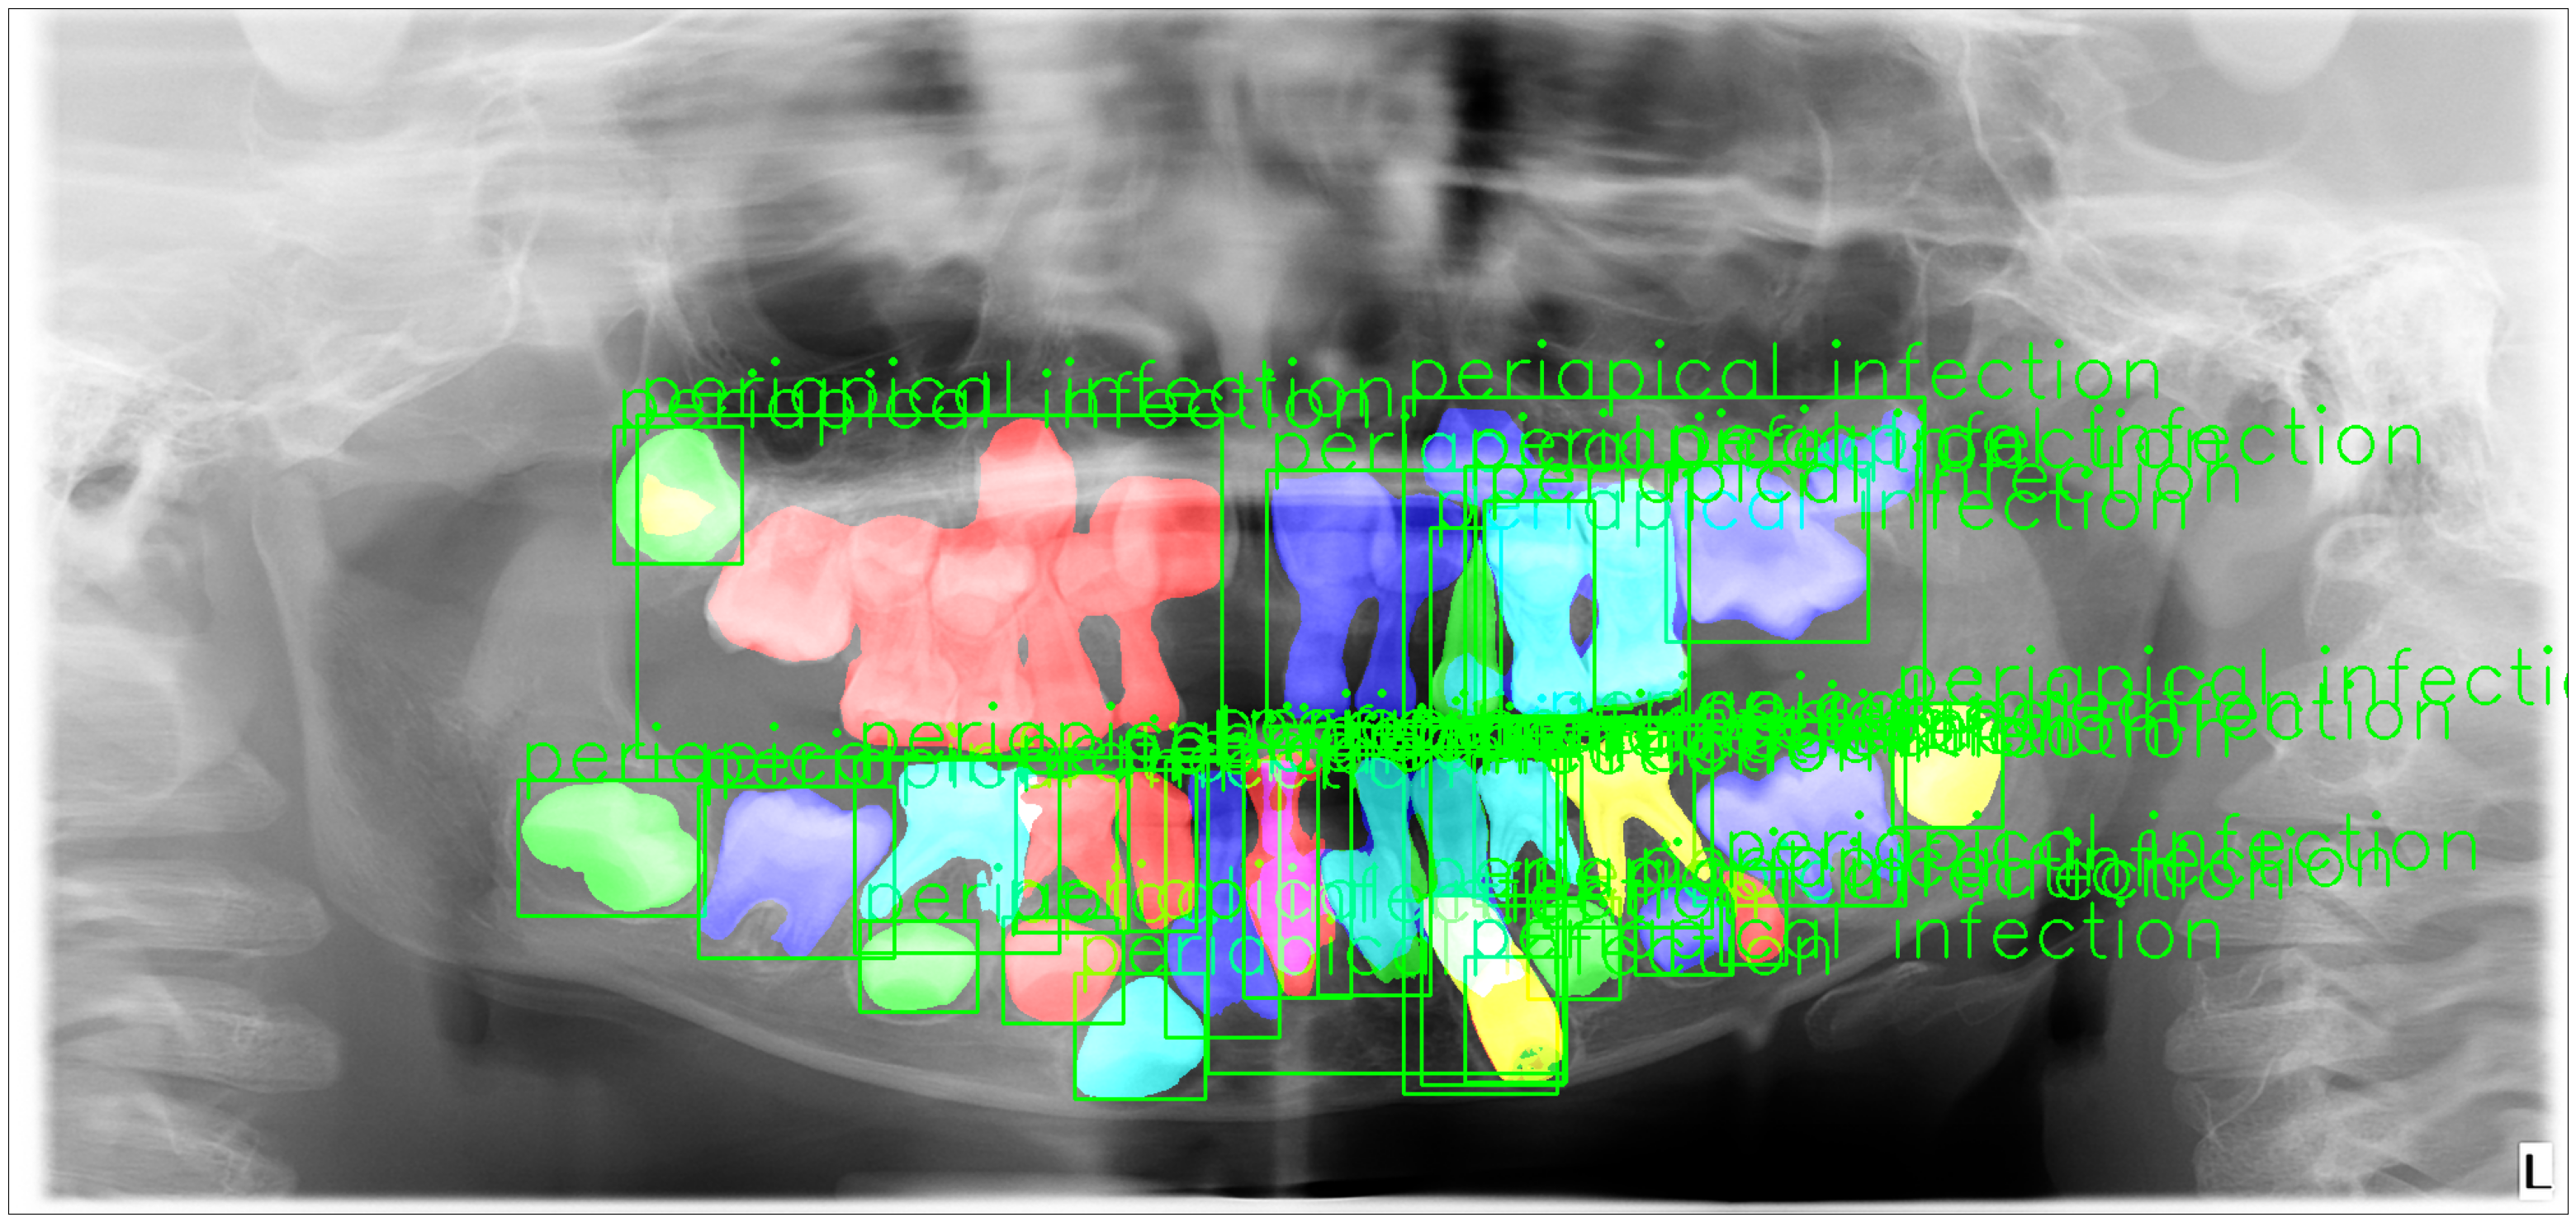

In [83]:
visualize_predictions(sample_img, confidence=0.5)

In [84]:
new_model=get_model_instance_segmentation(num_classes=6)

In [85]:
new_model.load_state_dict(torch.load("epoch_14.pth"))

<All keys matched successfully>

In [ ]:
new_model.to(device)
new_model.eval()

In [89]:
out=new_model([image])

In [92]:
out[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [93]:
def new_predict(img_path, confidence):

    img = Image.open(img_path)
    convert_tensor = transforms.ToTensor()

    img = convert_tensor(img)

    img = img.to(device)
    pred = new_model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

In [95]:
def new_visualize_predictions(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):

    masks, boxes, pred_cls = new_predict(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = color_mask(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.6, 0)
        boxes[i][0] = [int(i) for i in boxes[i][0]]
        boxes[i][1] = [int(i) for i in boxes[i][1]]

        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

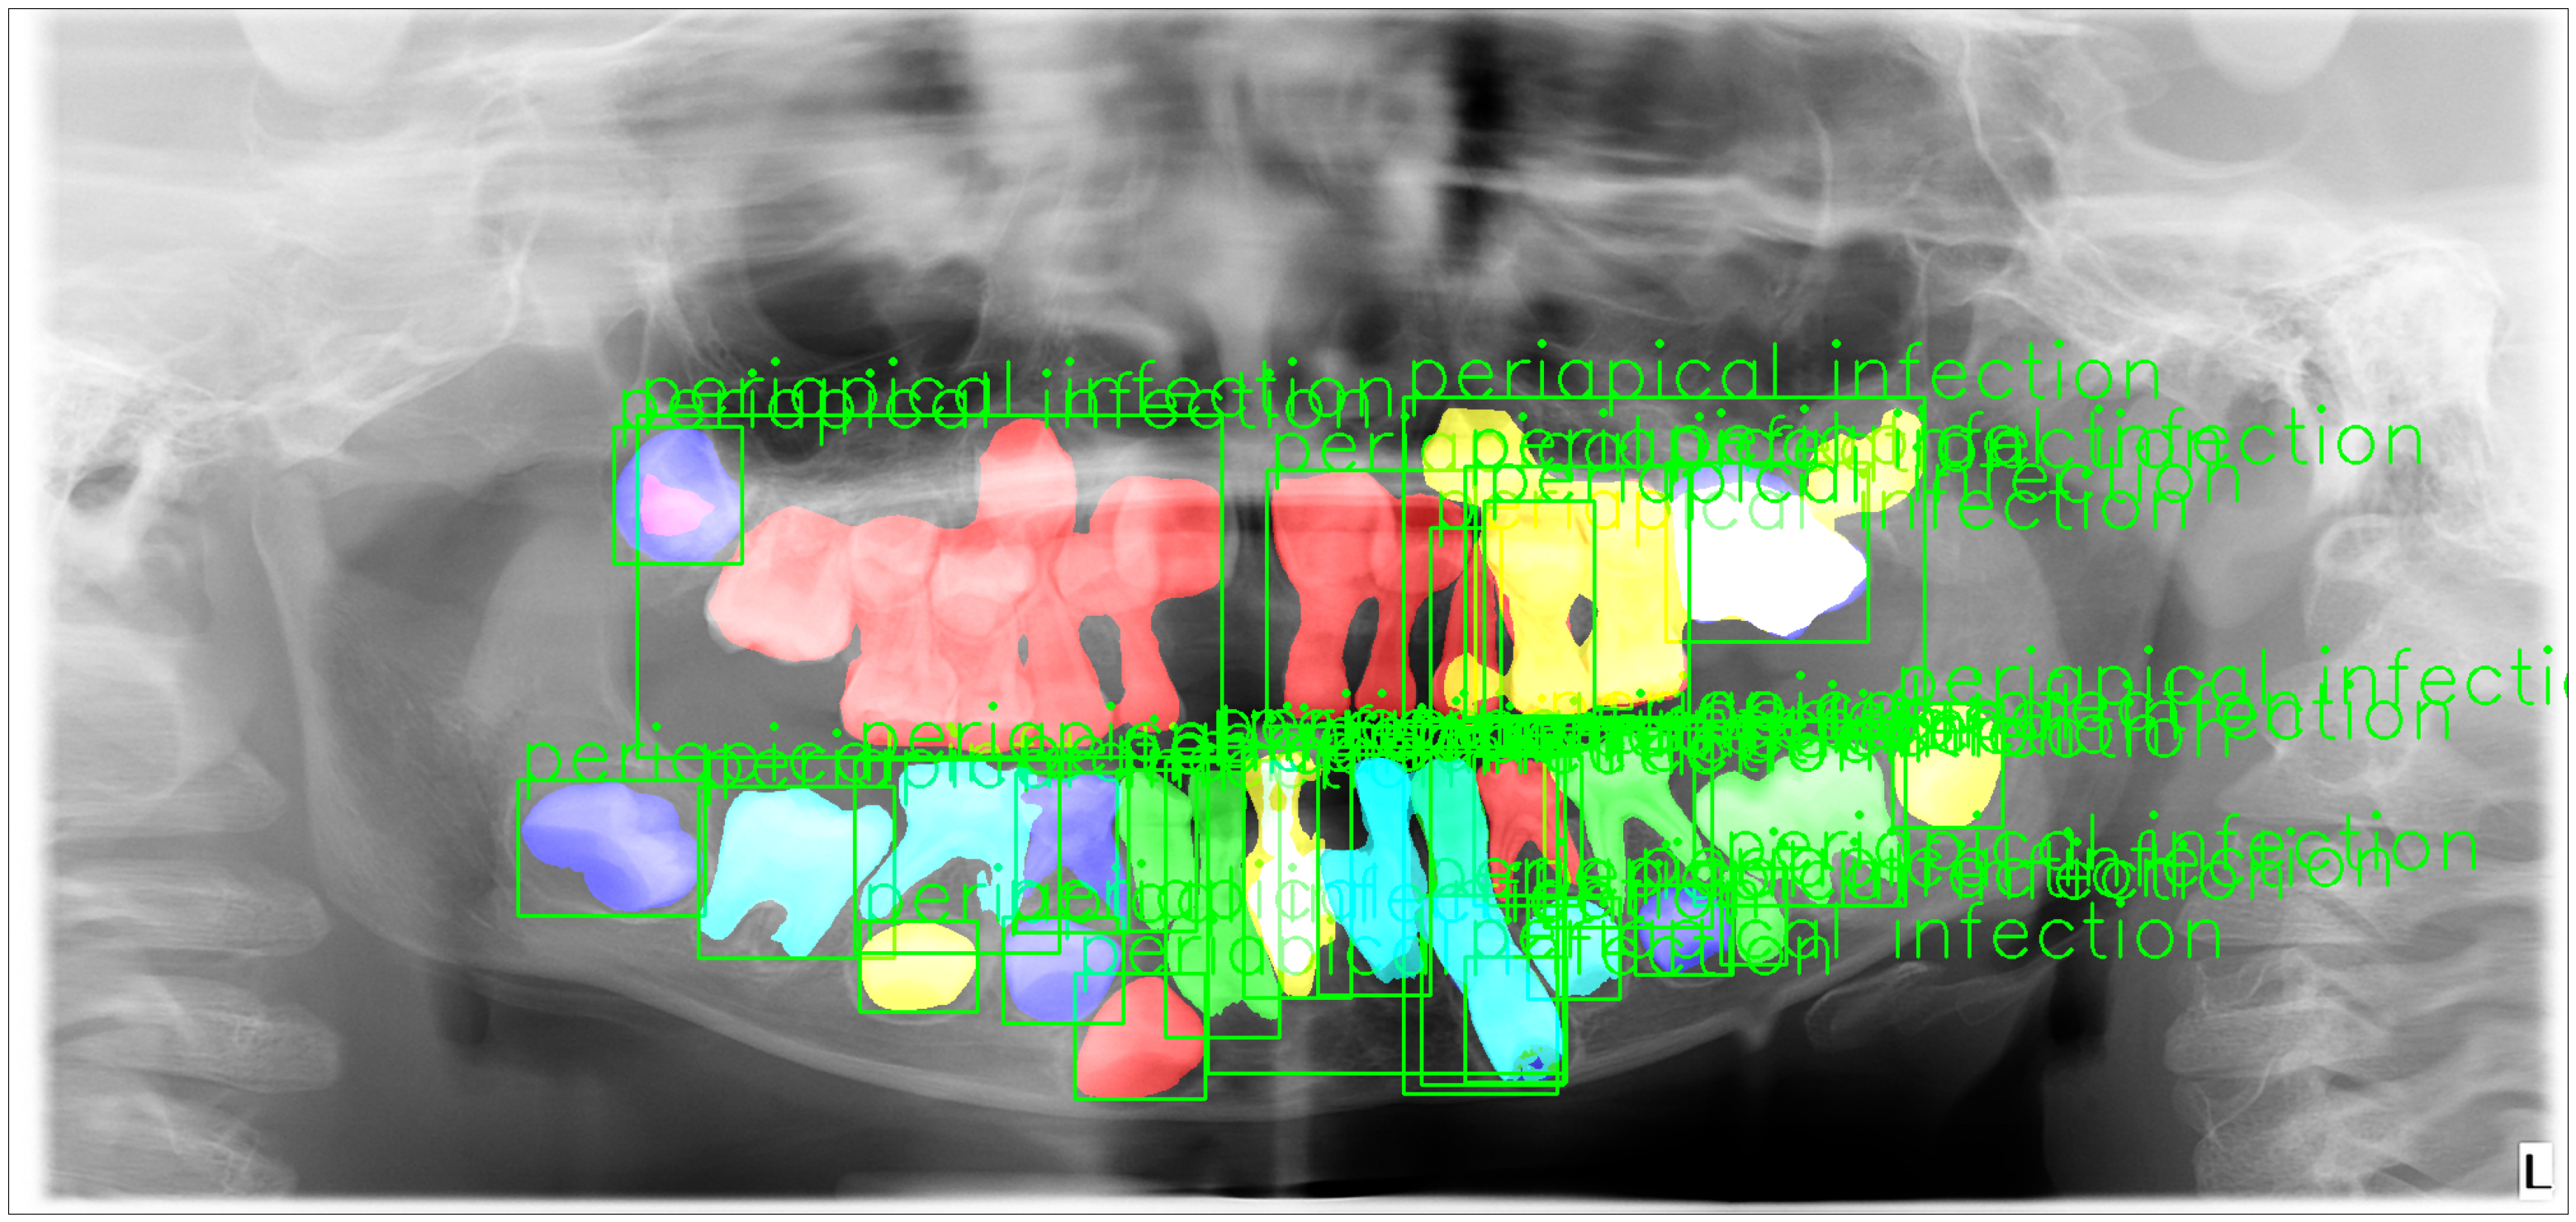

In [96]:
new_visualize_predictions(sample_img, confidence=0.5)